In [270]:
import sqlite3
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import emoji
import numpy as np
from itertools import chain

## Setting Up DataFrames

In [66]:
# Establish Connection to Database
conn = sqlite3.connect('data/chat.db')
cur = conn.cursor()

# Get All Table Names
cur.execute(" select name from sqlite_master where type = 'table' ")

for name in cur.fetchall():
    print(name)

('_SqliteDatabaseProperties',)
('deleted_messages',)
('sqlite_sequence',)
('chat_handle_join',)
('chat_message_join',)
('message_attachment_join',)
('handle',)
('message',)
('chat',)
('attachment',)
('sync_deleted_messages',)
('message_processing_task',)
('sync_deleted_chats',)
('sync_deleted_attachments',)
('kvtable',)
('sqlite_stat1',)


In [74]:
# Pass in Frames as pandas DataFrame
messages = pd.read_sql_query(
    '''SELECT *, 
    datetime(date/1000000000 + strftime("%s", "2001-01-01") ,
    "unixepoch",
    "localtime")  
    AS date_utc FROM message''', conn)
handles = pd.read_sql_query("SELECT * FROM handle", conn)
chat_message_joins = pd.read_sql_query("SELECT * FROM chat_message_join", conn)

In [75]:
# Rename ID Columns
messages.rename(columns={'ROWID' : 'message_id'}, inplace = True)
handles.rename(columns={'id' : 'phone_number', 'ROWID': 'handle_id'}, inplace = True)

In [93]:
# Set Additional Date Columns for Analysis
messages['message_date'] = messages['date']
messages['timestamp'] = messages['date_utc'].apply(lambda x: pd.Timestamp(x))
messages['date'] = messages['timestamp'].apply(lambda x: x.date())
messages['month'] = messages['timestamp'].apply(lambda x: int(x.month))
messages['year'] = messages['timestamp'].apply(lambda x: int(x.year))

In [102]:
#merge the messages with the handles
df_messages = pd.merge(
    messages[['text', 'handle_id', 'date', 'message_date', 'timestamp', 'month', 'year', 'is_sent', 'message_id']],  
    handles[['service', 'handle_id', 'phone_number']], on ='handle_id', how='left')

# and then that table with the chats
df_messages = pd.merge(
    df_messages, 
    chat_message_joins[['chat_id', 'message_id']], on = 'message_id', how='left')

## Visualizations

In [105]:
print("Oldest text is from:", min(df_messages['date']), 
      "Most recent text is from:", max(df_messages['date']), 
     "\nThere are", len(df_messages), "messages")

Oldest text is from: 2016-10-29 Most recent text is from: 2019-07-27 
There are 78977 messages


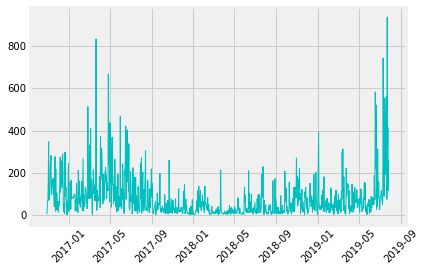

In [163]:
plt.plot(df_messages.groupby('date').size(), 'c-', linewidth= 1)
plt.xticks(rotation= '45')
plt.show()

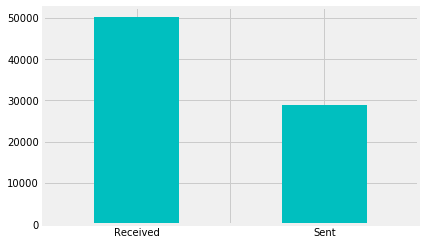

In [222]:
is_sent = pd.DataFrame(
    df_messages.groupby('is_sent').size()).transpose().rename(columns={0:'received', 1:'sent'})
plt.bar(left=[1,3], height=is_sent.iloc[0], width=0.9, color='c')
plt.xticks(range(5), ('', 'Received', '', 'Sent'))
plt.show()

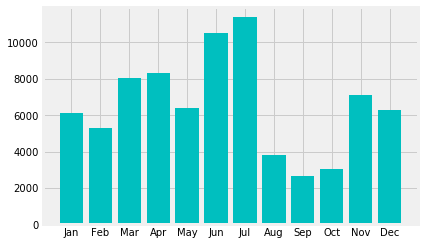

In [230]:
months = df_messages.groupby('month').size()
plt.bar(left=range(12), height=months, color='c')
plt.xticks(range(12), ('Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'))
plt.show()

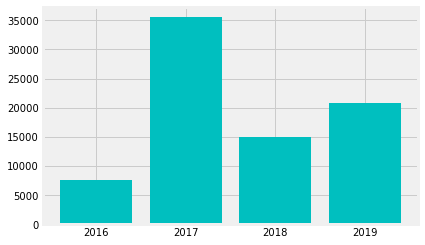

In [233]:
years = df_messages.groupby('year').size()
plt.bar(left=range(4), height=years, color='c')
plt.xticks(range(4), ('2016', '2017', '2018', '2019'))
plt.show()

In [363]:
def get_time(timestamp):
    try:
        return timestamp.hour
    except:
        return 

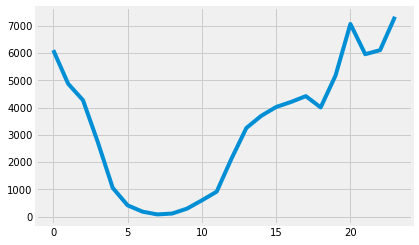

In [368]:
hours = pd.DataFrame(df_messages['timestamp'].apply(lambda x: get_time(x)))
hours = pd.DataFrame(hours.groupby('timestamp').size()).reset_index().rename(columns={0:'count'})
plt.plot(hours['count'])
plt.show()

In [251]:
def get_emojis(string):
    try:
        emojis = [emo for emo in string if emo in emoji.UNICODE_EMOJI]
    except TypeError:
        return 0
    if len(emojis) == 0:
        return 0
    else:
        return emojis

In [369]:
# Emojis I've Sent
emojis = df_messages[df_messages['is_sent'] == 1]['text'].apply(get_emojis)
emojis = list(chain.from_iterable(np.array(emojis[emojis != 0])))
df_emojis = pd.DataFrame(emojis).rename(columns={0:'emojis'})
df_emojis = pd.DataFrame(df_emojis.groupby('emojis').size()).reset_index().rename(columns={0:'count'})
df_emojis.sort_values('count', ascending=False).head(9)

,emojis,count
141,😂,102
165,😤,88
59,👀,78
96,💀,70
112,💦,63
146,😉,55
23,🅱,47
150,😎,40
168,😩,39


In [370]:
# Emojis I've Received
emojis = df_messages[df_messages['is_sent'] == 0]['text'].apply(get_emojis)
emojis = list(chain.from_iterable(np.array(emojis[emojis != 0])))
df_emojis = pd.DataFrame(emojis).rename(columns={0:'emojis'})
df_emojis = pd.DataFrame(df_emojis.groupby('emojis').size()).reset_index().rename(columns={0:'count'})
df_emojis.sort_values('count', ascending=False).head(9)

,emojis,count
200,😂,1689
222,😘,213
281,🤔,199
243,😭,174
211,😍,170
108,👀,126
35,🅱,105
148,💀,100
212,😎,99


In [236]:
'https://matplotlib.org/3.1.1/gallery/images_contours_and_fields/image_annotated_heatmap.html'

'https://matplotlib.org/3.1.1/gallery/images_contours_and_fields/image_annotated_heatmap.html'